In [1]:
import re
import pymorphy2
from nltk.corpus import stopwords
from pandas import read_csv, DataFrame
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.svm import SVR
import matplotlib.pyplot as plt

morph = pymorphy2.MorphAnalyzer()
stops = set(stopwords.words("english")) | set(stopwords.words("russian"))

def normalize(text):
    new_text = re.sub("[^а-яА-Яa-zA-Z]", " ", text)
    # lower case
    words = new_text.lower().split()
    # remove stop words
    words = [w for w in words if not w in stops]
    # normal form
    words = [morph.parse(w)[0].normal_form for w in words]
    return (words)

def get_name(reg_model):
     name = str(reg_model.named_steps['Reg'])
     name = name[:name.index('(')]
     return name
     

def reg_methods(reg_model): 
    model = {}
    model['name'] = get_name(reg_model)
    X = data.drop(['likes'],axis=1)
    Y = data['likes']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)
    reg_model.fit(x_train,y_train)        
    model['score'] = reg_model.score(x_test,y_test)
    return model
    

def paint_reg_methods(test_models): # Построение графика
    fig, axes = plt.subplots(figsize=(16, 4))
    test_models.score.plot(kind='barh', title='Regression Methods', fontsize=10, stacked=True)
    fig.savefig('result.png')


dataset = read_csv('test.tsv',sep ='\t',error_bad_lines=False)
data = DataFrame(dataset, columns=['likes','coms','favs','size','text'])

In [31]:
print(dataset.corr())


          likes      coms      favs      size
likes  1.000000  0.582814  0.722860  0.495249
coms   0.582814  1.000000  0.344495  0.181304
favs   0.722860  0.344495  1.000000  0.595168
size   0.495249  0.181304  0.595168  1.000000


In [2]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame[[self.key]]   
class Converter(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()
    
lin_reg = Pipeline([('union', FeatureUnion(
                transformer_list=[('text_vect', Pipeline([('selector', ItemSelector(key='text')),
                                                            ('converter', Converter()),
                                                          ('count_vect', TfidfVectorizer(tokenizer=normalize,stop_words = stops))])),
                                 ('coms_sc', Pipeline([('selector', ItemSelector(key='coms')),
                                                           ('std_scaler',  StandardScaler())])),
                                 ('favs_sc',Pipeline([('selector', ItemSelector(key='favs')),
                                                           ('std_scaler',  StandardScaler())])),
                                 ('size_sc',Pipeline([('selector', ItemSelector(key='size')),
                                                           ('std_scaler',  StandardScaler())]))],
                transformer_weights={'text_vect': 1.0,'coms_sc': 1.0,'favs_sc': 1.0,'size_sc': 1.0 })),

                          ('Reg', LinearRegression())])
rand_fores_reg = Pipeline([('union', FeatureUnion(
                transformer_list=[('text_vect', Pipeline([('selector', ItemSelector(key='text')),
                                                            ('converter', Converter()),
                                                          ('count_vect', TfidfVectorizer(tokenizer=normalize,stop_words = stops))])),
                                 ('coms_sc', Pipeline([('selector', ItemSelector(key='coms')),
                                                           ('std_scaler',  StandardScaler())])),
                                 ('favs_sc',Pipeline([('selector', ItemSelector(key='favs')),
                                                           ('std_scaler',  StandardScaler())])),
                                 ('size_sc',Pipeline([('selector', ItemSelector(key='size')),
                                                           ('std_scaler',  StandardScaler())]))],
                transformer_weights={'text_vect': 1.0,'coms_sc': 1.0,'favs_sc': 1.0,'size_sc': 1.0 })),
                          ('Reg', RandomForestRegressor(n_estimators=10, max_features='sqrt'))])
kneigh_reg = Pipeline([('union', FeatureUnion(
                transformer_list=[('text_vect', Pipeline([('selector', ItemSelector(key='text')),
                                                            ('converter', Converter()),
                                                          ('count_vect', TfidfVectorizer(tokenizer=normalize,stop_words = stops))])),
                                 ('coms_sc', Pipeline([('selector', ItemSelector(key='coms')),
                                                           ('std_scaler',  StandardScaler())])),
                                 ('favs_sc',Pipeline([('selector', ItemSelector(key='favs')),
                                                           ('std_scaler',  StandardScaler())])),
                                 ('size_sc',Pipeline([('selector', ItemSelector(key='size')),
                                                           ('std_scaler',  StandardScaler())]))],
                transformer_weights={'text_vect': 1.0,'coms_sc': 1.0,'favs_sc': 1.0,'size_sc': 1.0 })),
                          ('Reg', KNeighborsRegressor(n_neighbors=6))])
svr_reg = Pipeline([('union', FeatureUnion(
                transformer_list=[('text_vect', Pipeline([('selector', ItemSelector(key='text')),
                                                            ('converter', Converter()),
                                                          ('count_vect', TfidfVectorizer(tokenizer=normalize,stop_words = stops))])),
                                 ('coms_sc', Pipeline([('selector', ItemSelector(key='coms')),
                                                           ('std_scaler',  StandardScaler())])),
                                 ('favs_sc',Pipeline([('selector', ItemSelector(key='favs')),
                                                           ('std_scaler',  StandardScaler())])),
                                 ('size_sc',Pipeline([('selector', ItemSelector(key='size')),
                                                           ('std_scaler',  StandardScaler())]))],
                transformer_weights={'text_vect': 1.0,'coms_sc': 1.0,'favs_sc': 1.0,'size_sc': 1.0 })),
                          ('Reg',SVR(kernel='linear'))])

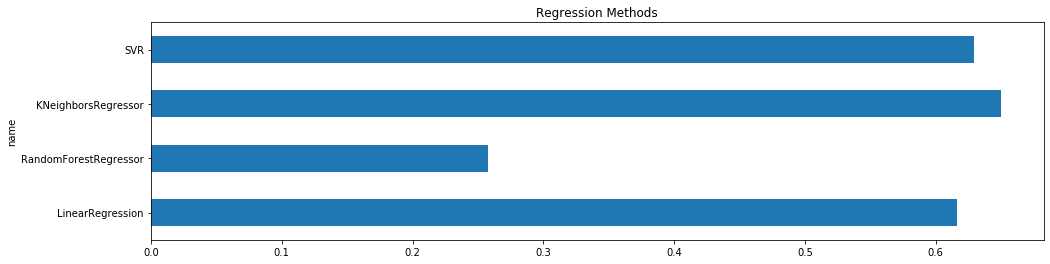

In [3]:
test_models = DataFrame()
test_models = test_models.append([reg_methods(lin_reg)],sort=True)
test_models = test_models.append([reg_methods(rand_fores_reg)],sort=True)
test_models = test_models.append([reg_methods(kneigh_reg)],sort=True)
test_models = test_models.append([reg_methods(svr_reg)],sort=True)
test_models.set_index('name',inplace=True)
paint_reg_methods(test_models)